In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

#semilla random
np.random.seed(0)

In [8]:
def map_range(value, min_=0, max_=1):
    """
    Normaliza los valores de una matriz 'value' a un rango especificado por 'min_' y 'max_'.

    Parámetros:
    - value (array-like): Matriz de valores a normalizar.
    - min_ (float, opcional): Valor mínimo del rango de salida. Por defecto es 0.
    - max_ (float, opcional): Valor máximo del rango de salida. Por defecto es 1.

    Retorna:
    - array-like: Matriz de valores normalizados en el nuevo rango.
    """
    return ((value-np.min(value))/(np.max(value)-np.min(value))) * (max_ - min_)

def generate_symbols(a0=0, a1=1, p_0=0.5, Nsamples=500, Nsymbols=100, var_noise=0.5, Diff=False):
    """
    Genera símbolos con ruido y los prepara para pruebas.

    Parámetros:
    - a0, a1 (float, opcional): Valores de los símbolos. Por defecto son 0 y 1.
    - p_0 (float, opcional): Probabilidad del símbolo 'a0'. Por defecto es 0.5.
    - Nsamples (int, opcional): Número de muestras por símbolo. Por defecto es 500.
    - Nsymbols (int, opcional): Número de símbolos. Por defecto es 100.
    - var_noise (float o tuple, opcional): Varianza del ruido. Puede ser un número o una tupla. Por defecto es 0.5.
    - Diff (bool, opcional): Si es True, aplica diferencia entre muestras consecutivas.

    Retorna:
    - tuple: Tres matrices correspondientes a los mensajes corruptos, los mensajes originales y el tiempo.
    """

    N=Nsamples*Nsymbols
    p_1 = 1 - p_0

    if type(var_noise) == tuple:
        data_test = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
        message_test_org = np.concatenate([[v]*Nsamples for v in data_test])
        message_test_corrupt = []

        noise_test_a0 = np.random.normal(0, var_noise[0], sum([1 for x in message_test_org if x == a0]))
        noise_test_a1 = np.random.normal(0, var_noise[1], sum([1 for x in message_test_org if x == a1]))

        for i in message_test_org:

            if i == a0:
                noise_simbol = noise_test_a0[0]
                noise_test_a0 = np.delete(noise_test_a0, 0)
            elif i == a1:
                noise_simbol = noise_test_a1[0]
                noise_test_a1 = np.delete(noise_test_a1, 0)

            message_test_corrupt.append(i + noise_simbol)
        message_test_corrupt = np.array(message_test_corrupt)
        
    else:
        noise_test = np.random.normal(0, var_noise, N)
        data_test = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
        message_test_org = np.concatenate([[v]*Nsamples for v in data_test])
        message_test_corrupt = message_test_org + noise_test

    #message_test_corrupt = np.array(np.split(message_test_corrupt, Nsymbols))

    if Diff == True:
        message_test_org_ = np.array(np.split(message_test_org, Nsymbols))
        message_test_org_ = np.abs(np.diff(message_test_org_, axis=0, prepend=0))
        message_test_corrupt = message_test_org_.flatten() + noise_test
        message_test_corrupt = np.array(np.split(message_test_corrupt, Nsymbols))
        message_test_org_ = message_test_org_.flatten()
        message_test_org = (message_test_org, message_test_org_)

    time = np.linspace(0,N,N)
    return message_test_corrupt, message_test_org, time   

/home/jony/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


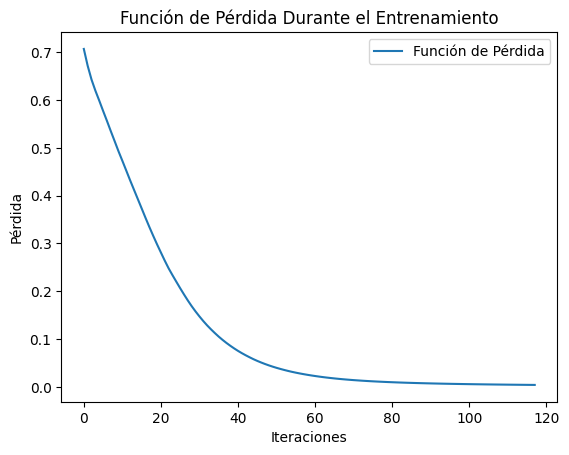

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class Model_Predict_simbol:
    def __init__(self,N=None):
        self.bluid_model()

    def bluid_model(self):
        try:
            self.model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(1000, 50), random_state=1)
        except:
            print('Error: do you need import: from sklearn.neural_network import MLPClassifier')
            

    def fill_model(self, simbol_predic_0=0, simbol_predic_1=1, metrics=False):
        self.model.fit([[simbol_predic_0],[simbol_predic_1]],[[simbol_predic_0],[simbol_predic_1]])

        if metrics == True:
            # Obtener la función de pérdida
            loss_values = self.model.loss_curve_
            plt.plot(loss_values, label='Función de Pérdida')
            plt.title('Función de Pérdida Durante el Entrenamiento')
            plt.xlabel('Iteraciones')
            plt.ylabel('Pérdida')
            plt.legend()
            plt.show()

    def predict(self, message, Nsamples):
        predicciones = self.model.predict(np.array(message).reshape(-1, 1))
        predicciones_ = np.array(np.split(predicciones, len(predicciones) // Nsamples))
        predicciones_ = np.mean(predicciones_, axis=1)
        predicciones_ = np.where(predicciones_ >= 0.5, 1, 0)
        return np.repeat(predicciones_, Nsamples)
    
    @staticmethod
    def plot_signals(predicted_signal, corrupt_signal=None, original_signal=None, time=None, n_samples=None):
        """
        Plots the predicted, corrupt, and original signals.

        :param predicted_signal: The predicted signal.
        :param corrupt_signal: (Optional) The corrupt signal.
        :param original_signal: (Optional) The original signal.
        :param time: (Optional) Time array for x-axis. If None, a range based on the length of the predicted_signal is used.
        :param n_samples: (Optional) Number of samples for major tick interval on x-axis.
        """
        
        plt.figure(figsize=(12, 6), tight_layout=True)

        # Create a time range if not provided
        if time is None:
            time = np.linspace(0, len(predicted_signal), len(predicted_signal))

        # Plot the original signal if provided
        if original_signal is not None:
            plt.step(time, original_signal, 'g', label='Señal Original', alpha=0.6)

        # Plot the corrupt signal if provided
        if corrupt_signal is not None:
            plt.step(time, map_range(corrupt_signal), 'b', label='Señal Corrupta', alpha=0.1)

        # Plot the predicted signal
        plt.step(time, predicted_signal, 'r', label='Señal Recuperada', alpha=0.6)

        # Set plot legend and grid
        plt.legend()
        if n_samples is not None:
            plt.gca().xaxis.set_major_locator(plt.MultipleLocator(n_samples))
        plt.grid(axis='x')  # Only vertical grid
        plt.show()

    @staticmethod
    def plt_cofusion_matrix(message_org, message_predict, Nsamples):
        conf_matrix = confusion_matrix(message_org, message_predict)/Nsamples
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
        plt.title('Matriz de Confusión')
        plt.xlabel('Predicciones')
        plt.ylabel('Valores Reales')
        plt.show()

clasifi = Model_Predict_simbol()
clasifi.fill_model(simbol_predic_0=0, simbol_predic_1=1, metrics=True)       


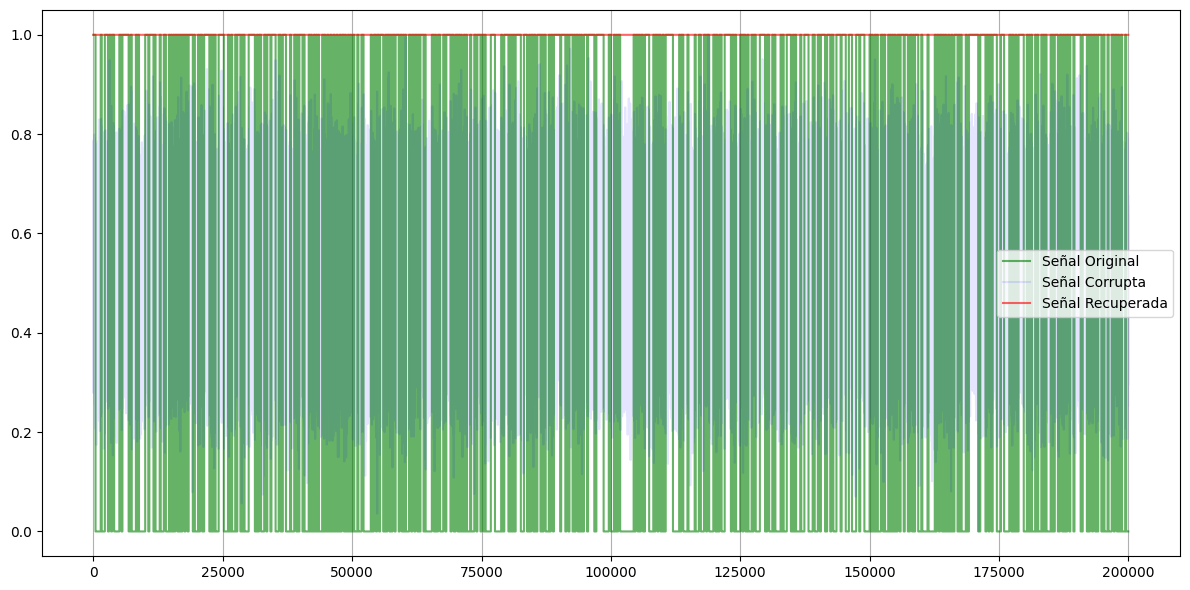

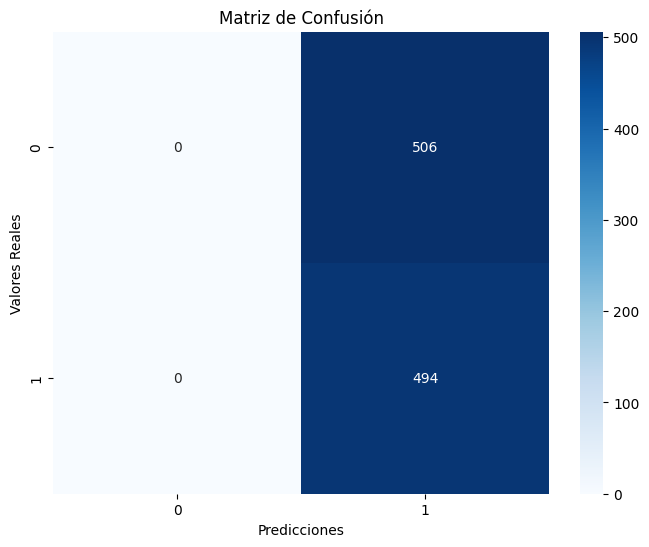

In [10]:
Nsamples = 200
message_corrupt_1, message_org_1, time_1 = generate_symbols(Nsamples=Nsamples, var_noise=2, Nsymbols=1000)
message_predict_1 = clasifi.predict(message_corrupt_1, Nsamples=Nsamples)

Model_Predict_simbol.plot_signals(message_predict_1, message_corrupt_1, message_org_1, time_1)
Model_Predict_simbol.plt_cofusion_matrix(message_org_1, message_predict_1, Nsamples)

